NOM, PRENOM: Azzouzi Oussama Abderraouf

In [132]:
# 1. Link drive and import library

# from google.colab import drive # pour l'accès au drive
import sys                     # pour l'accès au commandes système
import pandas as pd
import numpy as np
import json                    # pour manipuler le format JSON
import matplotlib.pyplot as plt
import scipy.signal as signal # pour filtre le EMG data
# montage du drive sur Colab (avec autorisation d'accès)
# drive.mount('/content/drive', force_remount=True)
# cliquez sur le lien affiché dans la console afin d'accéder à votre clé d'accès
# et recopiez cette clé dans la zone de saisie de texte.

In [133]:
# convert txt file to csv file

# 2. Import data
data_path = 'SubA_2kph_Group_1.txt'
data = pd.read_csv(data_path, sep='\t', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.1835,0.0372,-0.7700,-0.6100,0.6071,-0.4059,-0.5598,-0.3915,0.5896,-0.2982,...,-0.0188,-4.2628,-13.6728,2.0165,7.5388,12.8509,0.1927,0.5011,1.0794,7.0
1,0.1835,0.0371,-0.7701,-0.6099,0.6070,-0.4062,-0.5597,-0.3915,0.5895,-0.2980,...,-0.0374,-2.1483,-12.2728,2.0166,7.6582,12.8455,0.2313,0.5011,1.0408,17.0
2,0.1835,0.0371,-0.7701,-0.6098,0.6062,-0.4075,-0.5593,-0.3919,0.5895,-0.2971,...,-0.0472,-0.5628,-13.3400,2.0173,7.6284,12.7603,0.2313,0.5011,1.0408,27.0
3,0.1836,0.0371,-0.7701,-0.6098,0.6057,-0.4082,-0.5590,-0.3923,0.5900,-0.2958,...,-0.0146,-6.8985,-13.1052,2.0177,7.6263,12.7603,0.2313,0.5011,1.0408,37.0
4,0.1836,0.0371,-0.7701,-0.6098,0.6057,-0.4082,-0.5590,-0.3923,0.5900,-0.2958,...,-0.0146,0.6802,-12.9602,2.0166,7.6484,12.7558,0.2313,0.5011,1.0408,47.0


In [134]:
# 2. Data import from the saved txt file
# Sample raw_data
data_path = 'SubA_2kph_Group_1.txt'

# [Q1]. Read the data from the file. Split each line by the tab character ('\t') Using Pandas
df = pd.read_csv(data_path, sep='\t', header=None)

# [Q2]. Make a defintion 'extract_sensor_data' to allocate each sensor's data
def extract_sensor_data(df, start_col, end_col):
    data = df.iloc[:, start_col:end_col]
    data = np.array(data)
    data = data.astype(float)
    
    return data

# Define column ranges
qua_f = extract_sensor_data(df, 0, 4)
qua_s = extract_sensor_data(df, 4, 8)
qua_t = extract_sensor_data(df, 8, 12)
acc_f = extract_sensor_data(df, 12, 15)
acc_s = extract_sensor_data(df, 15, 18)
acc_t = extract_sensor_data(df, 18, 21)
gyr_f = extract_sensor_data(df, 21, 24)
gyr_s = extract_sensor_data(df, 24, 27)
gyr_t = extract_sensor_data(df, 27, 30)
emg = extract_sensor_data(df, 30, 32)
fsr = extract_sensor_data(df, 32, 35)

fsr

array([[ 2.0165,  7.5388, 12.8509],
       [ 2.0166,  7.6582, 12.8455],
       [ 2.0173,  7.6284, 12.7603],
       ...,
       [ 2.0163,  2.5756, 10.3664],
       [ 2.0172,  2.5749, 10.3656],
       [ 2.0172,  2.5749, 10.3656]])

In [135]:
# Function - Quaternion to rotation matrix
def quat2rot(Q):
    """
    Convert a quaternion to a 3x3 rotation matrix.
    Parameters:
    Q (list or numpy array): A quaternion as a list or numpy array [q0, q1, q2, q3].
    Returns:
    numpy array: A 3x3 rotation matrix.
    """
    q0, q1, q2, q3 = Q

    r00 = 2 * (q0*q0 + q1*q1) - 1
    r01 = 2 * (q1*q2 - q0*q3)
    r02 = 2 * (q1*q3 + q0*q2)
    r10 = 2 * (q1*q2 + q0*q3)
    r11 = 2 * (q0*q0 + q2*q2) - 1
    r12 = 2 * (q2*q3 - q0*q1)
    r20 = 2 * (q1*q3 - q0*q2)
    r21 = 2 * (q2*q3 + q0*q1)
    r22 = 2 * (q0*q0 + q3*q3) - 1

    R_GS = np.array([[r00, r01, r02],
                     [r10, r11, r12],
                     [r20, r21, r22]])

    return R_GS

# testing the function quat2rot
# aa = np.array(qua_f[0])
# aa = aa.astype(float)
quat2rot(qua_f[0])

array([[-0.92988782,  0.166582  , -0.327974  ],
       [-0.281158  ,  0.2531445 ,  0.9257476 ],
       [ 0.237206  ,  0.9530524 , -0.1884555 ]])


\begin{align*}
&\text{Calculate rotation matrix from upper to lower frame (post-multiply)} \\
&R^k = R^{t}_{BS}R^{t}_{GB} \times (R^{s}_{BS}R^{s}_{GB})^{-1} \\
&R^{a} = R^{s}_{BS}R^{s}_{GB} \times (R^{f}_{BS}R^{f}_{GB})^{-1} \\
& \\
&\text{Where } R_{BS} \text{ and } R_{GB}\text{ represent the rotation matrix from the body frame (B) to the sensor frame (S) and the global frame (G) to the body frame (B) regarding to tight (t), shank (s), foot (f) segments, respectitively.} \\
&\text{Note: } R_{BS} = (R_{SB})^{-1} = (R_{SB})^T \\
& \\
&\text{Calculate rotation angle of each joint} \\
&\theta_k = \arctan\left(\frac{R^{k}_{(1,1)}}{R^{k}_{(2,1)}}\right) \\
&\theta_a = \arctan\left(\frac{R^{a}_{(1,1)}}{R^{a}_{(2,1)}}\right) \\
\end{align*}



In [146]:
# 4. Joint Angle Calculation
# Assuming you have already loaded the data into the dataframes df_t, df_s, df_f


# Extract the quaternion columns by header names
# quat_columns = ['quat_1', 'quat_2', 'quat_3', 'quat_4']
# qua_t = df_t[quat_columns].values
# qua_s = df_s[quat_columns].values
# qua_f = df_f[quat_columns].values

# Define 3x3 matrices for R_SB_t, R_SB_s, and R_SB_f with specific values (Generate body frame to sensor frame rotation matrices R_BS)
R_BS_t = np.array([[-0.9972, 0.0716, -0.0221],
                   [0.0674, 0.9858, 0.1538],
                   [0.0328, 0.1519, -0.9879]])

R_BS_s = np.array([[0.2169, 0.9756, 0.0327],
                   [0.9652, -0.2194, 0.1426],
                   [0.1463, 0.0006, -0.9892]])

R_BS_f = np.array([[-0.8464, 0.2182, -0.4858],
                   [0.2039, 0.9755, 0.0830],
                   [0.4920, -0.0288, -0.8701]])

# Preallocate arrays for angle_k and angle_a
IMU_r, _ = qua_t.shape
angle_k = np.zeros(IMU_r)
angle_a = np.zeros(IMU_r)
angle_a_ori = np.zeros(IMU_r)

# Convert quaternions to rotation matrices and calculate angles
for i in range(IMU_r):
    # [Q4-1]. Convert quaternions to rotation matrices (Generate global frame to body frame rotation matrices R_GB)
    # Hint: Use quat2rot function for each segment in i-th step
    R_GB_t = quat2rot(qua_t[i])
    R_GB_s = quat2rot(qua_s[i])
    R_GB_f =  quat2rot(qua_f[i])

    # [Q4-2]. Calculate R_k and R_a
    R_k = R_BS_t.T @ R_GB_t @ np.linalg.inv(R_BS_s.T @ R_GB_s)
    R_a = R_BS_s.T @ R_GB_s @ np.linalg.inv(R_BS_f.T @ R_GB_f)

    # [Q4-3]. Calculate angles and apply mode adjustments
    angle_k[i] = (np.arctan2(R_k[0, 0] , R_k[1, 0]) * 180 / np.pi)
    angle_a_ori[i] =  (np.arctan2(R_a[0, 0] , R_a[1, 0]) * 180 / np.pi) 

    angle_a[i] = -angle_a_ori[i]+90 # Since the configuraion was rotated

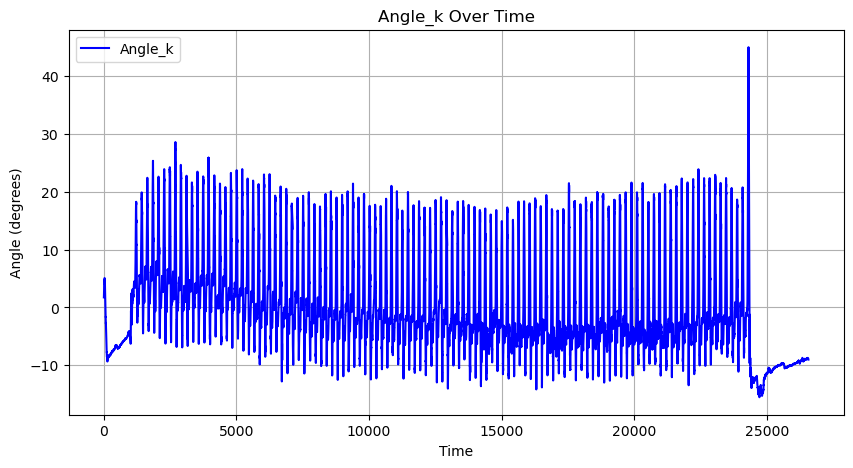

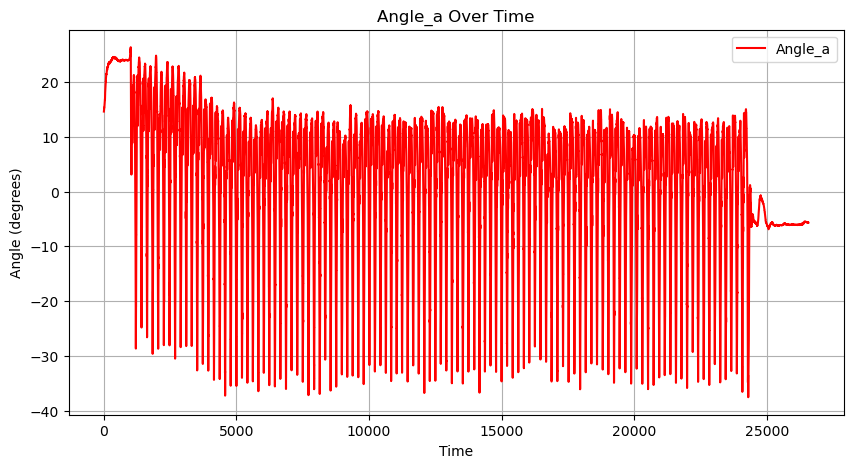

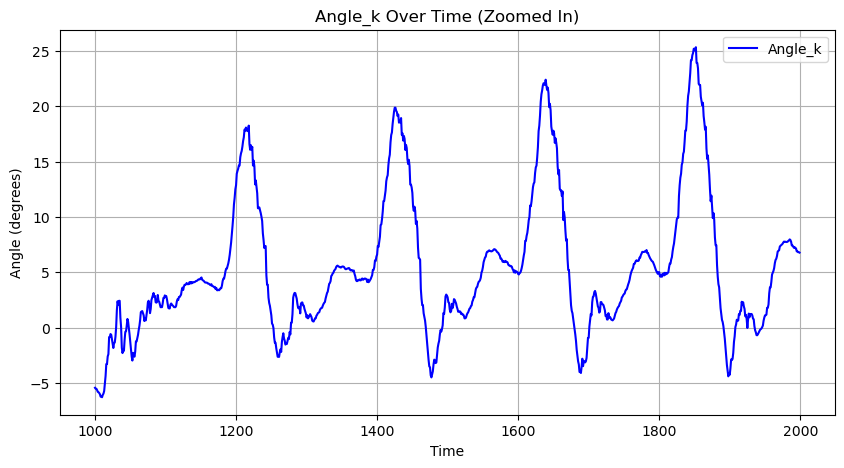

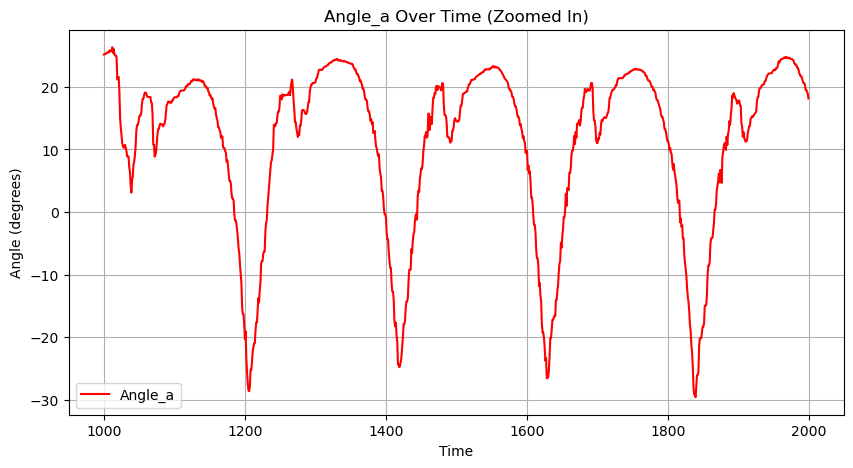

In [147]:
# 4-check. Joint Angle plot

# Assuming you have already calculated angle_k and angle_a arrays

# Create a time array (you can adjust this depending on your data)
time = range(IMU_r)  # You might want to use the actual time data from your dataset

# Plot angle_k
plt.figure(figsize=(10, 5))
plt.plot(time, angle_k, label='Angle_k', color='blue')
plt.xlabel('Time')
plt.ylabel('Angle (degrees)')
plt.title('Angle_k Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Plot angle_a
plt.figure(figsize=(10, 5))
plt.plot(time, angle_a, label='Angle_a', color='red')
plt.xlabel('Time')
plt.ylabel('Angle (degrees)')
plt.title('Angle_a Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Define the time range you want to zoom in on
start_time = 1000  # Start time index
end_time = 2000    # End time index

# Plot angle_k within the specified time range
plt.figure(figsize=(10, 5))
plt.plot(time[start_time:end_time], angle_k[start_time:end_time], label='Angle_k', color='blue')
plt.xlabel('Time')
plt.ylabel('Angle (degrees)')
plt.title('Angle_k Over Time (Zoomed In)')
plt.grid(True)
plt.legend()
plt.show()

# Plot angle_a within the specified time range
plt.figure(figsize=(10, 5))
plt.plot(time[start_time:end_time], angle_a[start_time:end_time], label='Angle_a', color='red')
plt.xlabel('Time')
plt.ylabel('Angle (degrees)')
plt.title('Angle_a Over Time (Zoomed In)')
plt.grid(True)
plt.legend()
plt.show()

In [97]:
# 5. FSR data to swing/stance detection

# Preallocate arrays for FSR data
r_fsr, _ = fsr.shape
fsr_flag = 0
refined_FSR = np.zeros(r_fsr)
tm = 0 # Timer

# Set your threshold values for fsr_data[i,2] and fsr_data[i,0:3] here
thr1 = 2.5 # Set your threshold value for fsr_data[i,2] here
thr2 = 2.5 # Set your threshold value for fsr_data[i,0:3] here

# [Q5]. Make a threshold-based swing foot detection algorithm
for i in range(len(fsr)):
    if fsr_flag == 0:
        # [Q5-1]. Reset the timer
        tm = 0

    if fsr[i, 2] > thr1:
        # [Q5-2]. Set the stance flag
        fsr_flag = 1
        tm = tm + 1

    # [Q5-3] Design if case when the swing case and set the flag value
    # Hint: Swing: all the value are less than thr2 value, and tm is higher than 400 ms (40)
    if all(fsr[i, 0:3] < thr2) and tm > 40:
        fsr_flag = 0
        tm = 0

    # [Q5-4] Design if case when the flag is onset
    # Hint: refine_FSR = 1(stance), = 0 (swing), tm is increasing during stance phase.
    if fsr_flag == 1:
        refined_FSR[i] = 1
        tm



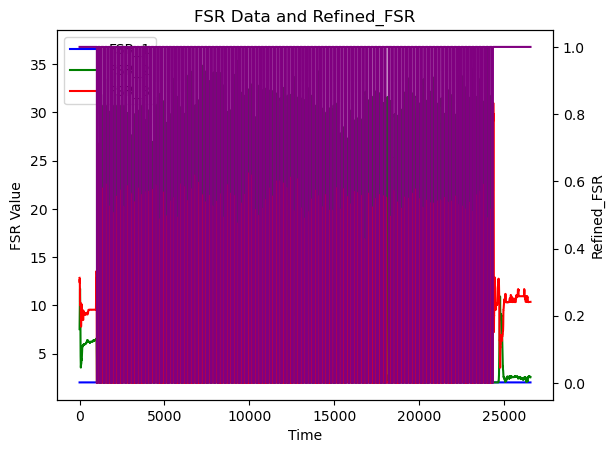

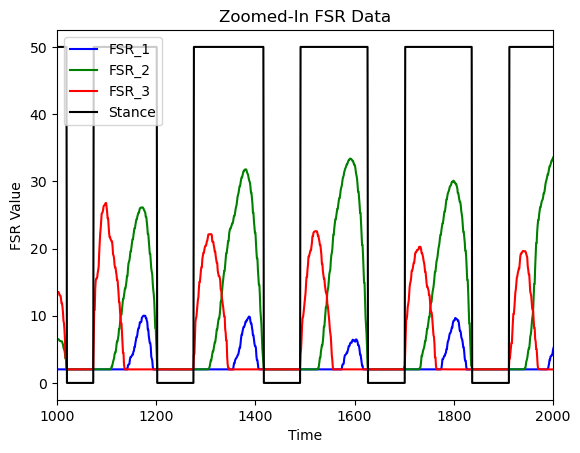

In [98]:
# 5-check FSR data plot

# Create a time vector (assuming you have one, replace it with your time data)
time = range(r_fsr)

# Initialize the figure
fig, ax1 = plt.subplots()

# Plot the raw FSR data
ax1.plot(time, fsr[:, 0], label='FSR_1', color='b')
ax1.plot(time, fsr[:, 1], label='FSR_2', color='g')
ax1.plot(time, fsr[:, 2], label='FSR_3', color='r')

ax1.set_xlabel('Time')
ax1.set_ylabel('FSR Value')
ax1.set_title('FSR Data and Refined_FSR')
ax1.legend(loc='upper left')

# Create a second y-axis for refined_FSR
ax2 = ax1.twinx()
ax2.plot(time, refined_FSR, label='Refined_FSR', color='purple')
ax2.set_ylabel('Refined_FSR')

# Zoomed-in plot
fig2, ax3 = plt.subplots()
ax3.plot(time, fsr[:, 0], label='FSR_1', color='b')
ax3.plot(time, fsr[:, 1], label='FSR_2', color='g')
ax3.plot(time, fsr[:, 2], label='FSR_3', color='r')
ax3.plot(time, refined_FSR*50, label='Stance', color='k')
ax3.set_xlabel('Time')
ax3.set_ylabel('FSR Value')
ax3.set_title('Zoomed-In FSR Data')
ax3.legend(loc='upper left')

# Specify the zoomed-in time range here
zoom_start = 1000  # Start index for zoomed-in view
zoom_end = 2000    # End index for zoomed-in view

# Set the x-axis limits for the zoomed-in plot
ax3.set_xlim(zoom_start, zoom_end)

plt.show()

In [ ]:
# 6. IMU data to swing/stance detection
m, n = qua_f.shape # Size of data
delta1 = np.zeros((5, 3))
T_c1 = 0
Lock1 = 0
Timer1 = 0
window1 = np.zeros(3)
SW_SD1 = np.zeros(m)

Df1 = np.zeros(m)
Tm = 30 # Time set constant
vv1 = np.zeros(m)
H1 = np.zeros(m)
V_WD1 = np.zeros(2)
# Array to store the values of a1 for plotting
a1_values = np.zeros((m, 3))
acc_pre = np.zeros_like(acc_f)  # This will create a zero array with the same shape as acc_f
delta = np.zeros((5, 3))  # Initialize delta with zeros
D = np.zeros(m)  # Initialize D with zeros
Df = np.zeros(m)  # Initialize Df with zeros
H = np.zeros(m)  # Initialize H with zeros
SW_SD = np.zeros((m, 1))  # Initialize SW_SD with zeros
window = np.zeros(3)  # Initialize window with zeros
V_WD = np.zeros(2)  # Initialize V_WD with zeros
vv = np.zeros(m)
T_c = 0
Lock = 0
Timer = 0


# IMU-based swing foot detection Algorithm
for i in range(m):
    rot_gs1 = quat2rot(qua_f[i, :])

    # [Q6-1]. Elliminate gravity vector from global frame acceleration, g=[0, 0, 9.8]
    # Hint: global frame acceleration= rot_gs1 x acc_f
    acc_pre[i,:] = np.dot(rot_gs1, acc_f[i, :]) - np.array([0, 0, 9.8]) # Gravity free acceleration
    
    sq_delta = np.sum(delta**2, axis=0)
    delta[:4, :] = delta[1:, :]
    delta[4, :] = acc_pre[i, :]

    # [Q6-2]. Generate manuever factor data from covariance matrics of gavity free acceleration
    # Hint: average of (sq_delta * standard deviation of delta matrix)
    D[i]

    if i > 0:
        Df[i] = 0.9 * D[i] + 0.1 * Df[i - 1]  # Smoothing singal from noise

    # [Q6-3]. Design if case when the toe off based on smoothing manuevor factor (Df)
    # If Df is higher than 50 (threshold value) then H=0 (Toe-off), else if, Df is less than 0.1 (threshold value) then H=1, else previous data
    if Df[i] : # Here the value is onset threshold value of Maneuver factor
        H[i]
    elif Df[i] :
        H[i]
    else:
        H[i]

    if H[i] == 1:
        T_c += 1
    else:
        T_c = 0

    if H[i] == 0 and Lock == 0:
        Lock = 1

    if Lock == 1:
        Timer += 1
        SW_SD[i, 0] = 1
        window[:2] = window[1:]
        window[2] = Df[i]
        V_WD[1] = window[2] - window[1]
        V_WD[0] = window[1] - window[0]
        V_WD_s= sum(V_WD)
        vv[i] = V_WD_s
    if Timer > 30:
        if V_WD[1] > 80 or (V_WD[0] > 80 and V_WD[1] > 80 and V_WD_s > 200):  # Here the value is offset threshold value of Derviative Maneuver factor
            SW_SD[i, 0] = 0
            Lock = 2

    if Lock == 2:
        SW_SD[i, 0] = 0
        Timer = 0
        window = np.zeros(3)

    if H[i] == 1 and Lock == 2 and T_c > 10:
        Lock = 0
        Timer = 0
        SW_SD[i, 0] = 0
        window = np.zeros(3)

    if T_c > 10:
        SW_SD[i, 0] = 0
        Lock = 0
        Timer = 0

In [100]:
# 6. IMU data to swing/stance detection
m, n = qua_f.shape # Size of data
delta1 = np.zeros((5, 3))
T_c1 = 0
Lock1 = 0
Timer1 = 0
window1 = np.zeros(3)
SW_SD1 = np.zeros(m)

Df1 = np.zeros(m)
Tm = 30 # Time set constant
vv1 = np.zeros(m)
H1 = np.zeros(m)
V_WD1 = np.zeros(2)
# Array to store the values of a1 for plotting
a1_values = np.zeros((m, 3))
acc_pre = np.zeros_like(acc_f)  # This will create a zero array with the same shape as acc_f
delta = np.zeros((5, 3))  # Initialize delta with zeros
D = np.zeros(m)  # Initialize D with zeros
Df = np.zeros(m)  # Initialize Df with zeros
H = np.zeros(m)  # Initialize H with zeros
SW_SD = np.zeros((m, 1))  # Initialize SW_SD with zeros
window = np.zeros(3)  # Initialize window with zeros
V_WD = np.zeros(2)  # Initialize V_WD with zeros
vv = np.zeros(m)
T_c = 0
Lock = 0
Timer = 0

# IMU-based swing foot detection Algorithm
for i in range(m):
    rot_gs1 = quat2rot(qua_f[i, :])

    # [Q6-1]. Elliminate gravity vector from global frame acceleration, g=[0, 0, 9.8]
    # Hint: global frame acceleration= rot_gs1 x acc_f
    acc_pre[i,:] = np.dot(rot_gs1, acc_f[i, :]) - np.array([0, 0, 9.8]) # Gravity free acceleration

    sq_delta = np.sum(delta**2, axis=0)
    delta[:4, :] = delta[1:, :]
    delta[4, :] = acc_pre[i, :]

    # [Q6-2]. Generate manuever factor data from covariance matrics of gavity free acceleration
    # Hint: average of (sq_delta * standard deviation of delta matrix)
    D[i] = np.mean(sq_delta * np.std(delta, axis=0))

    if i > 0:
        Df[i] = 0.9 * D[i] + 0.1 * Df[i - 1]  # Smoothing singal from noise

    # [Q6-3]. Design if case when the toe off based on smoothing manuevor factor (Df)
    # If Df is higher than 50 (threshold value) then H=0 (Toe-off), else if, Df is less than 0.1 (threshold value) then H=1, else previous data
    if Df[i] > 50: # Here the value is onset threshold value of Maneuver factor
        H[i] = 0
    elif Df[i] < 0.1:
        H[i] = 1
    else:
        H[i] = H[i-1] if i > 0 else 0

    if H[i] == 1:
        T_c += 1
    else:
        T_c = 0

    if H[i] == 0 and Lock == 0:
        Lock = 1

    if Lock == 1:
        Timer += 1
        SW_SD[i, 0] = 1
        window[:2] = window[1:]
        window[2] = Df[i]
        V_WD[1] = window[2] - window[1]
        V_WD[0] = window[1] - window[0]
        V_WD_s= sum(V_WD)
        vv[i] = V_WD_s
    if Timer > 30:
        if V_WD[1] > 80 or (V_WD[0] > 80 and V_WD[1] > 80 and V_WD_s > 200):  # Here the value is offset threshold value of Derviative Maneuver factor
            SW_SD[i, 0] = 0
            Lock = 2

    if Lock == 2:
        SW_SD[i, 0] = 0
        Timer = 0
        window = np.zeros(3)

    if H[i] == 1 and Lock == 2 and T_c > 10:
        Lock = 0
        Timer = 0
        SW_SD[i, 0] = 0
        window = np.zeros(3)

    if T_c > 10:
        SW_SD[i, 0] = 0
        Lock = 0
        Timer = 0

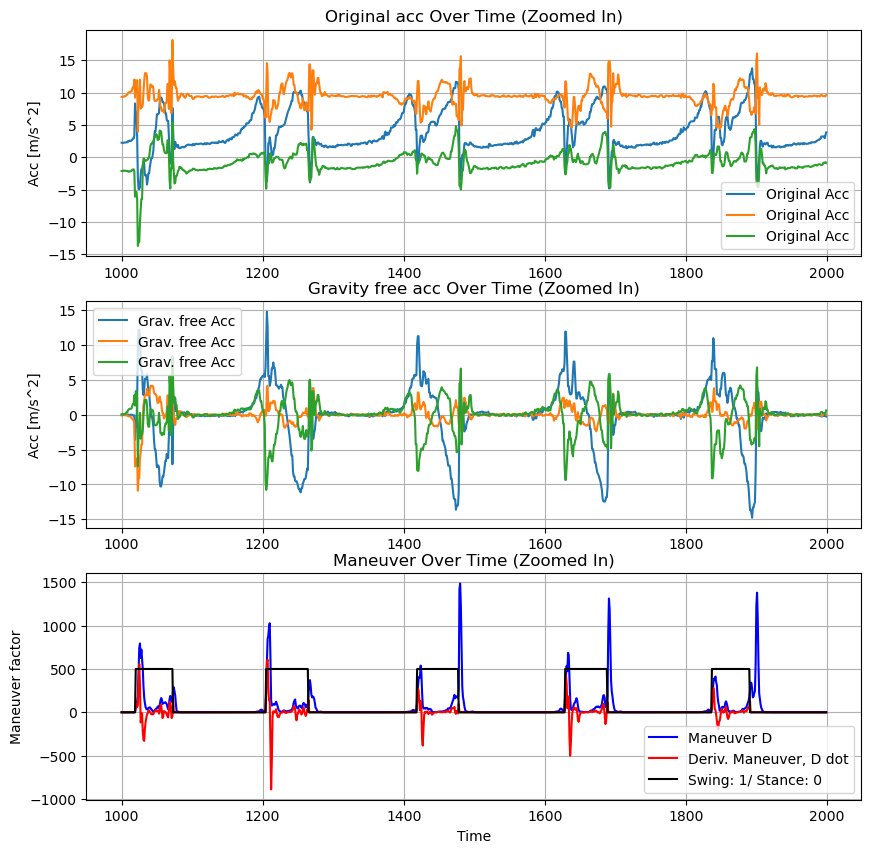

In [101]:
# Define the time range you want to zoom in on
start_time = 1000  # Start time index
end_time = 2000    # End time index
# Figure for each data
plt.figure(figsize=(10, 10))

# Df subplot
plt.subplot(3, 1, 1)
plt.plot(time[start_time:end_time], acc_f[start_time:end_time], label='Original Acc')
plt.ylabel('Acc [m/s^2]')
plt.title('Original acc Over Time (Zoomed In)')
plt.grid(True)
plt.legend()

# vv subplot
plt.subplot(3, 1, 2)
plt.plot(time[start_time:end_time], acc_pre[start_time:end_time], label='Grav. free Acc')
plt.ylabel('Acc [m/s^2]')
plt.title('Gravity free acc Over Time (Zoomed In)')
plt.grid(True)
plt.legend()

# SW_SD subplot
plt.subplot(3, 1, 3)
plt.plot(time[start_time:end_time], Df[start_time:end_time], label='Maneuver D', color='blue')
plt.plot(time[start_time:end_time], vv[start_time:end_time], label='Deriv. Maneuver, D dot', color='r')
plt.plot(time[start_time:end_time], 500*SW_SD[start_time:end_time], label='Swing: 1/ Stance: 0', color='k')
plt.xlabel('Time')
plt.ylabel('Maneuver factor')
plt.title('Maneuver Over Time (Zoomed In)')
plt.grid(True)
plt.legend()

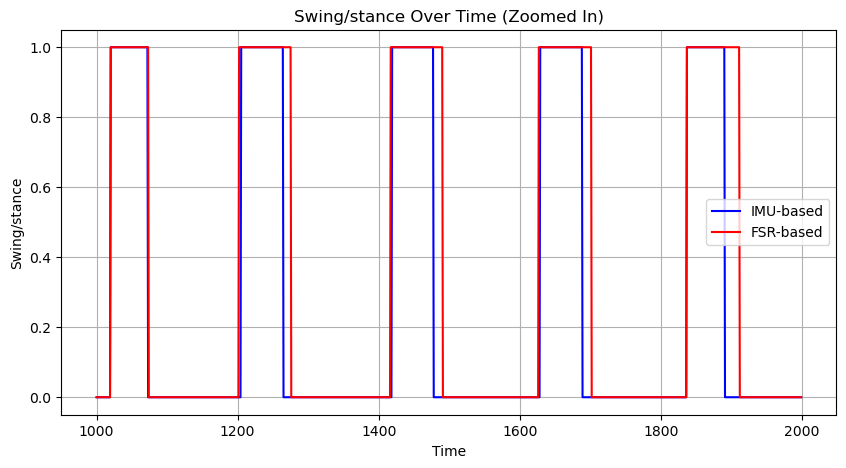

In [105]:
# Define the time range you want to zoom in on
start_time = 1000  # Start time index
end_time = 2000    # End time index
# Figure for each data

# [Q6-4]. Ploting the FSR-based detection graph and IMU-based detection graph at the same plot
# Hint: Fsr should be flipped because its detect stance phase not the swing phase
SW_FSR = 1 - refined_FSR

plt.figure(figsize=(10, 5))
plt.plot(time[start_time:end_time], SW_SD[start_time:end_time], label='IMU-based', color='blue')
plt.plot(time[start_time:end_time], SW_FSR[start_time:end_time], label='FSR-based', color='red')

plt.xlabel('Time')
plt.ylabel('Swing/stance')
plt.title('Swing/stance Over Time (Zoomed In)')

plt.grid(True)
plt.legend()
plt.show()

In [112]:

# 7. EMG data calculation

# [Q7-1]. Define the sampling frequency (Fs) and filter parameters(EMG's sampling freq. of 100Hz, Highpass filter cut-off freq. of 25Hz, Lowpass filter cut-off freq. of 4Hz)
Fs = 100  # Sample rate (replace with your actual sampling rate)
highpass_freq = 25  # High-pass filter frequency
lowpass_freq = 4   # Low-pass filter frequency

# Initialize arrays to store filtered EMG data for each channel
filtered_emg_data = np.zeros_like(emg)
Data_hp = np.zeros_like(emg)
Data_rf = np.zeros_like(emg)
Data_lp = np.zeros_like(emg)

# [Q7-hint] Butter worthy filter function: signal.butter(n-th order, cut-off frequency, 'type', fs=sampling frequency)
# Process each EMG channel separately
for channel in range(emg.shape[1]):

    # [Q7-2]. Design the 4th order butter-worth type high-pass filter
    highpass_filter = signal.butter(4, highpass_freq, 'high', fs=Fs)

    # Apply the high-pass filter to the current channel
    Data_hp[:, channel] = signal.filtfilt(highpass_filter[0], highpass_filter[1], emg[:, channel])

    # [Q7-3]. Rectify the data by taking the absolute value
    Data_rf[:, channel] = np.abs(Data_hp[:, channel])

    # [Q7-4]. Design the 4th order butter-worth type low-pass filter
    lowpass_filter = signal.butter(4, lowpass_freq, 'low', fs=Fs)

    # Apply the low-pass filter to the absolute value of Data_bp
    Data_lp[:, channel] = signal.filtfilt(lowpass_filter[0], lowpass_filter[1], Data_rf[:, channel])

    # Store the filtered data in the corresponding channel of the result array
    filtered_emg_data[:, channel] = Data_lp[:, channel]

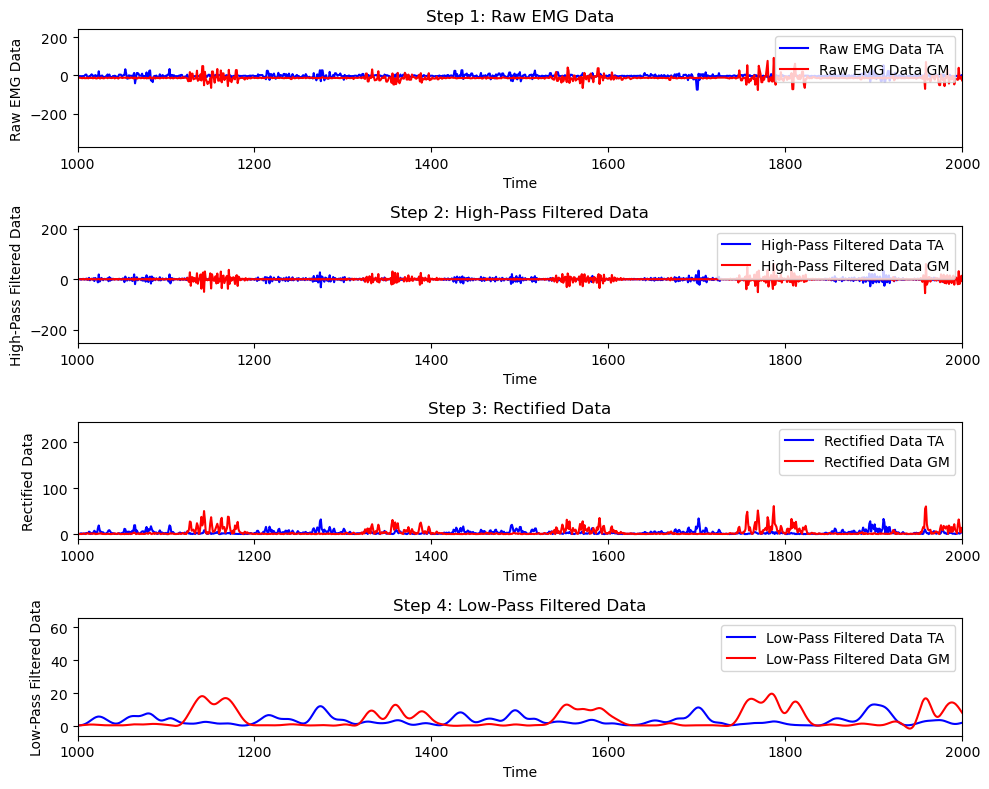

In [113]:
# 7-check EMG data plot
# Create a time vector (replace with your actual time vector if available)
time = np.arange(len(emg))

# Initialize the figure for raw data
fig, axs = plt.subplots(4, figsize=(10, 8))

# Plot the raw EMG data
axs[0].plot(time, emg[:, 0], label='Raw EMG Data TA', color='b')
axs[0].plot(time, emg[:, 1], label='Raw EMG Data GM', color='r')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Raw EMG Data')
axs[0].set_title('Step 1: Raw EMG Data')
axs[0].legend(loc='upper right')

# Plot the high-pass filtered data
axs[1].plot(time, Data_hp[:, 0], label='High-Pass Filtered Data TA', color='b')
axs[1].plot(time, Data_hp[:, 1], label='High-Pass Filtered Data GM', color='r')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('High-Pass Filtered Data')
axs[1].set_title('Step 2: High-Pass Filtered Data')
axs[1].legend(loc='upper right')

# Plot the rectified data
axs[2].plot(time, Data_rf[:, 0], label='Rectified Data TA', color='b')
axs[2].plot(time, Data_rf[:, 1], label='Rectified Data GM', color='r')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Rectified Data')
axs[2].set_title('Step 3: Rectified Data')
axs[2].legend(loc='upper right')

# Plot the low-pass filtered data
axs[3].plot(time, Data_lp[:, 0], label='Low-Pass Filtered Data TA', color='b')
axs[3].plot(time, Data_lp[:, 1], label='Low-Pass Filtered Data GM', color='r')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Low-Pass Filtered Data')
axs[3].set_title('Step 4: Low-Pass Filtered Data')
axs[3].legend(loc='upper right')

# Specify the zoomed-in time range here
zoom_start = 1000  # Start index for zoomed-in view
zoom_end = 2000    # End index for zoomed-in view

# Set the x-axis limits for the zoomed-in plots
for ax in axs:
    ax.set_xlim(zoom_start, zoom_end)

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

plt.show()


In [115]:
# 8. Gait statistic evaluation

def seperate_step(vector):
    step_num = 0
    step_time_data = []
    for i in range(1, len(vector)):
        if vector[i - 1] > vector[i]:
            if step_num >= len(step_time_data) or step_time_data[step_num][0] == 0:
                step_time_data.append([i, 0, 0])
            else:
                step_time_data[step_num][2] = i - 1
                step_num += 1
                step_time_data.append([i, 0, 0])

        if vector[i - 1] < vector[i]:
            if step_num < len(step_time_data):
                step_time_data[step_num][1] = i

    # Remove incomplete step data
    step_time_data = [s for s in step_time_data if 0 not in s]

    return step_time_data

def extraction_gait_parm(step_time_data, acc, time, swing):
    dT = 0.01

    stride_time = []
    swing_time = []
    cadence = []
    stride_length = []
    gait_velocity = []

    for step in step_time_data:
        dt = 0.01
        foot_v = np.array([0.0, 0.0])
        foot_p = np.array([0.0, 0.0])

        for j in range(step[0], step[2]):
            foot_v += acc[j, 1:2] * dt
            foot_p += foot_v * dt

        foot_p += foot_v * dt
        stride_t = (time[step[2]] - time[step[0]])*dt
        swing_t = (time[step[2]] - time[step[1]])*dt
        stride_len = np.sqrt(foot_p[0]**2 + foot_p[1]**2)

        stride_time.append(stride_t)
        swing_time.append(swing_t)
        cadence.append(2 * 60 / stride_t)
        stride_length.append(stride_len)
        gait_velocity.append(stride_len / stride_t)

    out = {
        'strideTime': stride_time,
        'swingTime': swing_time,
        'stanceDuration': [s / st for s, st in zip(swing_time, stride_time)],
        'cadence': cadence,
        'strideLength': stride_length,
        'gaitVelocity': gait_velocity
    }

    return out

# Create a time vector (assuming you have one, replace it with your time data)
vector = refined_FSR
time = np.arange(len(vector))
step_time_data = seperate_step(vector)
out = extraction_gait_parm(step_time_data, acc_pre, time, vector)

# Calculate statistics
def calculate_statistics(data):
    return {
        # [Q8-1] filled return value for each statistic data 'max', 'min', 'mean', 'std'
        'max': np.max(data),
        'min': np.min(data),
        'mean': np.mean(data),
        'std': np.std(data)
   
    }

# [Q8-2] Generate dictionary for 1. statistical analysis Swing Time [s], 2. Stride Time [s], 3. Stance ratio [%], 4. Stride Length [m], 5. Gait Speed [m/s], 6. Cadence [steps/min]
statistics = {
    'Swing_time [s]': calculate_statistics(out['swingTime']),
    'Stride_time [s]': calculate_statistics(out['strideTime']),
    'Stance_ratio [%]': calculate_statistics(out['stanceDuration']),
    'Stride_length [m]': calculate_statistics(out['strideLength']),
    'Gait_speed [m/s]': calculate_statistics(out['gaitVelocity']),
    'Cadence [steps/min]': calculate_statistics(out['cadence'])
}

# To dataFrame for clear view
df_statistics = pd.DataFrame(statistics)

# [Q8-3] print statistic data
print(df_statistics)

      Swing_time [s]  Stride_time [s]  Stance_ratio [%]  Stride_length [m]  \
max         1.770000         2.500000          0.793103           1.896199   
min         1.270000         1.740000          0.623810           0.010369   
mean        1.357027         2.086216          0.650664           0.661274   
std         0.049767         0.067678          0.018389           0.340467   

      Gait_speed [m/s]  Cadence [steps/min]  
max           1.089770            68.965517  
min           0.005033            48.000000  
mean          0.317858            57.581785  
std           0.169203             1.911325  


# *Vous avez fait un excellent travail, c'est la fin de l'examen!"*